# Rolling diffusion analysis

Version: 03 June 2024 | Korak Ray

David Rueda lab - Single-Molecule Imaging Group at MRC-LMS/Imperial College London

--------------------------------------------------------------------------------

Features of the script:
- Import 1D position vs time trajectory
- Calculate rolling diffusion coefficient
- Plot and save position and rolling diffusion vs time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy  
from scipy import optimize
from scipy.optimize import leastsq, curve_fit

In [2]:
trace1_ssds = np.loadtxt('tracked_data__trace_0_Kymo 92__20240104-165357.csv', delimiter=',')

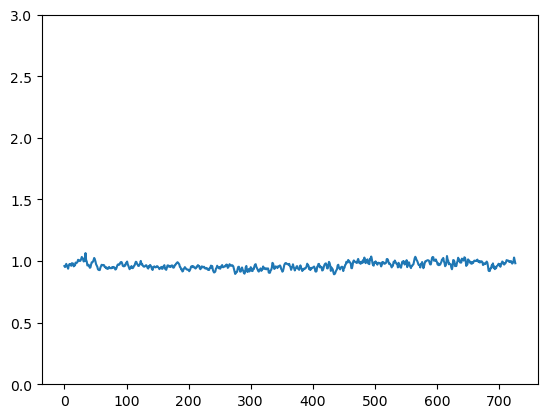

In [101]:
plt.plot(trace1_ssds[13:-33,1])
plt.ylim(0,3)

# use if you want to discard some portion of the trajectory that was overfitted

# trace1_ssds_trim = trace1_ssds[13:-33]

# otherwise

trace1_ssds_trim = trace1_ssds.copy()

In [20]:
def line(x, m): #defines the function to be fit for MSD
    
    return m*x 

In [21]:
# Mean squared displacement calculation

def MSD(window,maxTau,trace):
    
    result=[]
    taus=[]
    err=[]
    SD=[]
    
    for tau in range(1,maxTau+1): #loop to get all the different MSDs
        
        displacementsSquared=[]
        
        for i in range(0,window-tau): #loop to get d^2's
            
            dx=trace[i+tau]-trace[i] #displacement
            displacementsSquared.append(dx**2)
            
        SD.append(displacementsSquared)
        result.append(np.mean(displacementsSquared))
        taus.append(tau)
        err.append(np.std(displacementsSquared))
        
    return result,taus,err,SD #returns list of MSDs, taus, errors, and SDs

In [22]:
# weighted calculation of diffusion coefficient

def D(data_full,window,maxTau):
    
    result=[]
    offset=[]
    var=[]

    data = data_full[:,1] # positions
    dt = data_full[2,0] - data_full[1,0] # time 

    for i in range(0,len(data)-window+1): #loop to calculate all Ds
        
        y,x,y_err,SD=MSD(window,maxTau,data[i:i+window])
        popt, pcov = curve_fit(line, x, y, sigma=y_err,bounds=(0,np.inf)) # gradient (2*diffusion coefficient)
        result.append(popt[0]/2)

    return np.array(result)/dt,offset,var #returns list of diffusion coefficient


In [23]:
window = 16
result1_ssds,_,_ = D(trace1_ssds_trim, window, maxTau=3)


In [24]:
def um2bp(um):
    return (um)*(1/0.00034)**2  

def bp2um(bp):
    return (bp)/(1/0.00034)**2  

In [25]:
def plot_traceD(time, trace, D_trace, window, relative=0.):
    
    # D_trace : rolling D for trace positions
    # window : window size
    # relative : position from which relative displacement is measured
    
    time -= time[0] # set time zero
    trace -= relative # set position zero
    
    fig,axs = plt.subplots(2, sharex = True, figsize=(6,6))
    
    # position plot
    axs[0].set_xlim(0,50)
    axs[0].plot(time, trace, color='k')
    axs[0].set_ylim(-1.2,3.2)
    axs[0].axhline(0, lw=3,color='k', alpha=0.3) # position of feature of interest
    
    # diffusion plot
    axs[1].semilogy(time[window//2:-window//2+1], D_trace, color='#2180b9')
    secay = axs[1].secondary_yaxis('right', functions=(um2bp, bp2um))
    axs[1].set_ylim(1e-4,2)
    axs[1].axhline(0.0064, ls='--',color='#2180b9', alpha=0.31) # threshold for static v dynamic
    
    return fig,axs

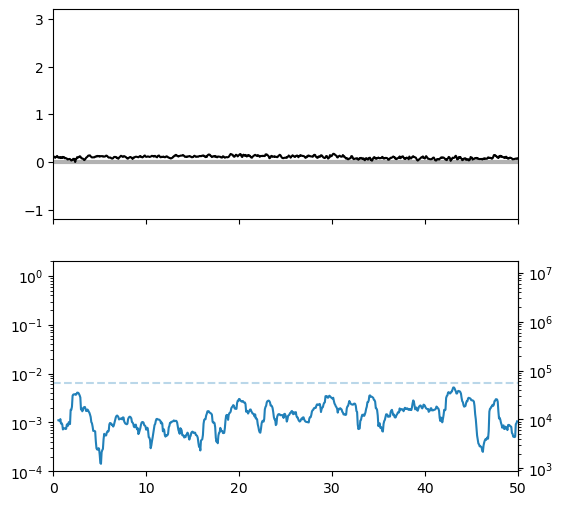

In [26]:
fig, axs = plot_traceD(trace1_ssds_trim[:, 0].copy(), -trace1_ssds_trim[:, 1].copy(),
                       result1_ssds, window, -trace1_ssds_trim[:, 1].max())
plt.savefig('figs/wtD2I_gap_stall_1.pdf')
plt.show()